In [2]:
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def plot_SIR_timeline(time_series, name=None, save=False):
    plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
    plt.plot(time_series.index, time_series['infected'], label = 'infected')
    plt.plot(time_series.index, time_series['removed'], label = 'removed')
    plt.legend()
    plt.title(f'SP Network - {name}')
    if save: plt.savefig(f'SP network Simulation- {name}.png', fromat='png', dpi = 300)
    plt.show()
    
def plot_capacity(time_series, name=None, save=True):
    plt.plot(time_series.index, time_series['hospitalized'], label = 'Hospitalized')
    plt.plot(time_series.index, len(time_series.index)*[0.0025], label = 'Capacity')
    plt.legend()
    plt.title(f'SP Network - {name}')
    if save: plt.savefig(f'Hospital Beds- {name}.png', fromat='png', dpi = 300)
    plt.show()

In [3]:
import numpy as np
from scipy.stats import truncnorm

def sample_truncated_norm(clip_low, clip_high, mean, std):
    a, b = (clip_low - mean) / std, (clip_high - mean) / std
    return int(truncnorm.rvs(a, b, mean, std))

def sample_incubation(clip_low = 2, clip_high = 15, mean = 6, std = 3):
    return sample_truncated_norm(clip_low, clip_high, mean, std)

def sample_onset_to_hosp_or_asymp(clip_low = 2, clip_high = 21, mean = 6.2, std = 4.3):
    return sample_truncated_norm(clip_low, clip_high, mean, std)

def sample_hospitalization_to_removed(clip_low = 2, clip_high = 32, mean = 8.6, std = 6.7):
    return sample_truncated_norm(clip_low, clip_high, mean, std)


def needs_hospitalization(age):
    #https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf
    if age <= 9:  return np.random.random() <= 0.001 
    if age <= 19: return np.random.random() <= 0.003
    if age <= 29: return np.random.random() <= 0.012
    if age <= 39: return np.random.random() <= 0.032
    if age <= 49: return np.random.random() <= 0.049
    if age <= 59: return np.random.random() <= 0.102
    if age <= 69: return np.random.random() <= 0.166
    if age <= 79: return np.random.random() <= 0.243
    return np.random.random() <= 0.273

def hospitalized_needs_ICU(age):
    #https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf
    if age <= 9:  return np.random.random() <= 0.05 
    if age <= 19: return np.random.random() <= 0.05
    if age <= 29: return np.random.random() <= 0.05
    if age <= 39: return np.random.random() <= 0.05
    if age <= 49: return np.random.random() <= 0.063
    if age <= 59: return np.random.random() <= 0.122
    if age <= 69: return np.random.random() <= 0.274
    if age <= 79: return np.random.random() <= 0.432
    return np.random.random() <= 0.709

def susceptible_to_exposed(node, day):
    if node['status'] != 'susceptible':
        print(node)
        raise ValueError("Node status different from susceptible")
    
    node['status'] = 'exposed'
    node['period_duration'] = sample_incubation()
    node['infection_day'] = day
    
    return

def exposed_to_infected(node):
    if node['status'] != 'exposed':
        raise ValueError("Node status different from exposed")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
    
    node['status'] = 'infected'
    node['period_duration'] = sample_onset_to_hosp_or_asymp()
    
    return
    
def infected_to_new_state(node):
    if node['status'] != 'infected':
        raise ValueError("Node status different from infected")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
    
    if needs_hospitalization(node['age']):
        node['status'] = 'hospitalized'
        node['period_duration'] = sample_hospitalization_to_removed()
    else:
        node['status'] = 'removed'
        
    return
        
def hospitalized_to_removed(node):
    if node['status'] != 'hospitalized':
        raise ValueError("Node status different from hospitalized")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
        
    node['status'] = 'removed'
    
    return

def change_state(node):
    if node['status'] == 'exposed':
        exposed_to_infected(node)
        return
    if node['status'] == 'infected':
        infected_to_new_state(node)
        return 
    if node['status'] == 'hospitalized':
        hospitalized_to_removed(node)
        return 

def update_node(node):
    if node['status'] == 'susceptible' or node['status'] == 'removed':
        return
    if node['period_duration'] == 0: 
        change_state(node)
        return 
    
    node['period_duration'] = node['period_duration'] - 1
    return

def infect_node(node, day):
    susceptible_to_exposed(node, day)
    return

def infect_graph(Graph, node_list, day):
    for n in node_list:
        infect_node(Graph.nodes[n], day)

def update_graph(Graph):
    for i, node in Graph.nodes(data=True):
        update_node(node)
        

In [4]:
import numpy as np
import networkx as nx
import pandas as pd
import collections
from tqdm import tqdm

# Start with pct% of population infected
def init_graph(initial_infection = .05, graph_model = 'relaxed_caveman',
               pop_size = 1000, seed = None):
    if graph_model == 'relaxed_caveman':
        G = nx.relaxed_caveman_graph(int(pop_size/4), 5, 0.4, seed)
    elif graph_model == 'scale_free':
        G = nx.scale_free_graph(pop_size, seed=seed)
    elif graph_model == 'SP':
        G = nx.read_gpickle('graph_SP_05_20.gpickle')
    else:
        raise ValueError("Unknown graph type")
    
    init_infection(G, initial_infection)

    return G

def init_parameters(initial_infection, graph_model, pop_size = 1000, seed=None):
    G = init_graph(initial_infection, graph_model, pop_size, seed)
    
    status = current_status(G)
    
    pop = len(G.nodes)
    i = status['infected'] / pop
    s = (pop - i) / pop
    newly_infected = status['infected']
    r, contacts_infected = 0, 0

    data = [[s,i, r, newly_infected, contacts_infected]]

    return G, data, status, pop

def init_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """   
    for node in G.nodes():
        G.nodes[node].update({
                      'status': 'susceptible', 
                      'infection_day' : -1, 
                      'contacts_infected' : 0
        })

    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size, replace = False)
    
    for i in infected:
        susceptible_to_exposed(G.nodes[i], 0)

def lambda_leak_value(infected_ratio, max_value=0.05, exp=3): 
    return (infected_ratio**exp)*max_value

def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and removed
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result

def current_status_by_zone(G):   
    result = collections.Counter(node['home'] for i,node in G.nodes(data=True) \
                                            if node['status']=='infected')

    people_per_zone = dict(collections.Counter(node['home'] for i,node in G.nodes(data=True)))
    
    for k,v in result.items():
        result[k] = v/people_per_zone[k]
        
    return dict(result)


def get_mean_contacts_infected(G):
        contacts_infected = [node['contacts_infected'] for i, node in G.nodes(data=True)\
                                                             if node['status'] == 'removed']
        if len(contacts_infected) > 0: 
            contacts_infected = np.mean(contacts_infected)
        else:
            contacts_infected = np.nan
            
        return contacts_infected
    
def get_time_series_row(G, pop):
    status = current_status(G)
    s = status['susceptible'] / pop
    i = status['infected'] / pop
    r = status['removed'] / pop
    h = status['hospitalized'] / pop
    e = status['exposed'] / pop

    contacts_infected = get_mean_contacts_infected(G)
    
    return s, e, i, r, h, contacts_infected, status

In [5]:
def node_contacts(G, node, p_r, restrictions, lambda_leak):
    if G.nodes[node]['status'] == 'susceptible':
        if np.random.random() < lambda_leak:
            return node, np.nan
        for node, contact, data in G.edges(node, data=True):
            if G.nodes[contact]['status'] == 'infected': 
                relation = data['edge_type']
                if np.random.random() < p_r[relation] * (1 - restrictions[relation]):
                    return node, contact
    return None, None
    
def spread_through_contacts(G, p_r, restrictions, lambda_leak):
    results = [node_contacts(G, node, p_r, restrictions, lambda_leak) for node in G.nodes()]
    results = np.array(results)
    results =  results[results[:,0] != np.array(None)]
    exposed, contacts_responsible = results[:,0], results[:,1]
    
    return exposed, contacts_responsible

def expose_contacts(G, exposed, day):
    for node in exposed:
        infect_node(G.nodes[node], day)

def increment_contacts_infected(G, contacts_responsible):
    series = pd.Series(contacts_responsible).dropna().value_counts()
    for index, value in series.items():
        G.nodes[index]['contacts_infected'] += value
        
        
def spread_one_step(G, p_r, restrictions, lambda_leak, day):
    exposed, contacts_responsible = spread_through_contacts(G, p_r, restrictions, lambda_leak)
    
    if len(exposed) > 0: 
        expose_contacts(G, exposed, day)
    if len(contacts_responsible) > 0: 
        increment_contacts_infected(G, contacts_responsible)
    
    return len(exposed)

In [9]:
def simulate_pandemic(restrictions={'work':0, 'school': 0, 'home':0},
                                  initial_infection=.05, 
                                  p_r={'work':.3, 'school':.5, 'home':.7},
                                  lambda_leak=0,
                                  graph_model = 'SP', pop_size = None,
                                  seed = None, it=None, policy=False):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    np.random.seed(seed)
    
    G, data, status, pop = init_parameters(initial_infection, graph_model, pop_size, seed)
    
    data_per_region = []
       
    zones = range(1, 343)
    
    policy_chosen = []
    
    infected_per_relation = {
        'home': 0,
        'work' : 0,
        'school': 0
    }
    
    for day in tqdm(range(500)):
        
        if (status['removed']+status['susceptible'])>=pop:
            break
            
        update_graph(G)
       
        s, e, i, r, h, contacts_infected, status = get_time_series_row(G, pop)

        data.append([s, e, i, r, h, contacts_infected])
        
        
        if graph_model == 'SP':
            
            data_per_region.append(current_status_by_zone(G))
            
            #Lockdown
            if policy:
                if h > 0.00125: restrictions['work'], restrictions['school'] = 1, 1
                else: restrictions['work'], restrictions['school'] = 0, 0
            
            policy_chosen.append(list(restrictions.values()))
            
            newly_infected = spread_one_step(G, p_r, restrictions, lambda_leak, day)
        
            data[-1].append(newly_infected)
        
    columns = ['susceptible', 'exposed', 'infected', 'removed', 'hospitalized', 
               'contacts_infected_mean', 'newly_infected']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series, G, data_per_region, infected_per_relation, policy_chosen

In [7]:
import plotly.graph_objects as go

def run_simulations(number_of_rounds):
    sims = Parallel(n_jobs=-1)(delayed(simulate_pandemic)\
                               (initial_infection = .0001) for i in tqdm(range(number_of_rounds)))
    return sims

def plot_average_infection_curve(sims):
    fig = go.Figure()
    
    sims = np.array(sims)[:,0]
    
    for col in ['infected']:
        tmp=[sims[i][col] for i in range(len(sims))]
        infected_sims = pd.DataFrame(tmp).T.fillna(0)
        infected_sims['mean'] = infected_sims.apply(np.mean, axis=1)
        infected_sims['sd'] = infected_sims.drop(columns='mean').apply(np.std, axis=1)
        infected_sims = infected_sims.drop(columns=col)
    
    x = infected_sims.index.to_list()
    y = infected_sims['mean']
    sd = infected_sims['sd']

    fig.add_trace(go.Scatter(x=x, y=y,
        fill=None,
        mode='lines',
        line_color='indigo',
         name="Average Curve"
        ))

    fig.add_trace(go.Scatter(x=x, y=y+sd,
        fill=None,
        mode='lines',
        line_color='magenta',
        showlegend=False
       ))

    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        fill='tonexty', # fill area between trace0 and trace1
        mode='lines', line_color='indigo',      name="Standard Deviation"))

    fig.add_trace(go.Scatter(x=x, y=y-sd,
        fill=None,
        mode='lines',
        line_color='magenta',    showlegend=False
        ))


    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        fill='tonexty', # fill area between trace0 and trace1
        mode='lines', line_color='indigo',     showlegend=False
    ))

    fig.update_layout(title = 'Average infection Curve - Relaxed Caveman')

    fig.show()

In [27]:
sims = run_simulations(6)
plot_average_infection_curve(sims)

100%|██████████| 6/6 [00:00<00:00, 44.04it/s]


 23%|██▎       | 113/500 [01:13<04:13,  1.53it/s]


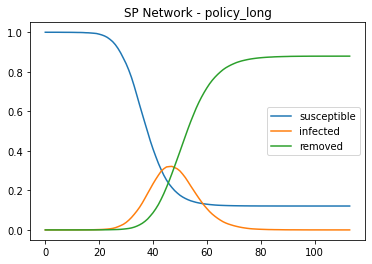

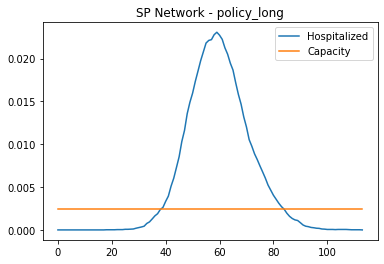

In [10]:
time_series, G, data_per_region, infcted_per_relation,policy_chosen = simulate_pandemic(initial_infection = .0001)
plot_SIR_timeline(time_series, 'policy_long', False)
plot_capacity(time_series, 'policy_long', False)

In [ ]:
plt.plot(time_series.index, time_series['hospitalized'], label = 'Hospitalized')
plt.plot(time_series.index, len(time_series.index)*[0.0025], label = 'Capacity')
plt.title(f'SP Network - policy')
plt.fill_between(time_series.index[:-1], time_series['hospitalized'].max(), where=np.array(policy_chosen)[:,1] == 1,
                facecolor='red', alpha=0.1, label='lockdown')
plt.legend()
plt.title(f'SP Network - policy')
plt.savefig(f'Hospital Beds- policy.png', fromat='png', dpi = 300)
plt.show()

policy_chosen

In [151]:
Parallel(n_jobs=-1)(delayed(np.sqrt)(x) for x in range(10000000000000000))

exception calling callback for <Future at 0x7fba373b8a50 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/selector

KeyboardInterrupt: 

exception calling callback for <Future at 0x7fba38f1d450 state=finished raised BrokenProcessPool>
Traceback (most recent call last):
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/site-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/site-packages/joblib/parallel.py", line 780, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/site-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/site-packages/joblib/parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/yamba/anaconda3/envs/cmdp/lib/python3.7/site-packages/joblib/_par

In [37]:
G.edges('03380996101', data=True)

EdgeDataView([('03380996101', '01610034104', {'edge_type': 'work', 'zone': 161.0})])

In [40]:
G.edges('03381342101', data=True)

EdgeDataView([('03381342101', '03050060101', {'edge_type': 'work', 'zone': 338.0}), ('03381342101', '03341097101', {'edge_type': 'work', 'zone': 338.0})])

In [50]:
G.nodes

'03422109102'

In [41]:
G.edges('03381342101', data=True)

EdgeDataView([('03381342101', '03050060101', {'edge_type': 'work', 'zone': 338.0}), ('03381342101', '03341097101', {'edge_type': 'work', 'zone': 338.0})])

In [57]:
5524
5525
5505


Comando Final - 5508


SyntaxError: 'return' outside function (<ipython-input-57-c62732efbf7e>, line 7)

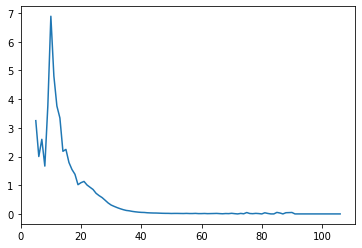

In [134]:
plt.plot(time_series.index[5:], 
         time_series['newly_infected'][5:]/(time_series['infected'][5:]*len(G.nodes)),
         label = 'newly_infected')

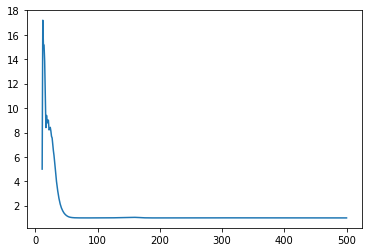

In [48]:
plt.plot(time_series.index, time_series['newly_infected'], label = 'r_0')


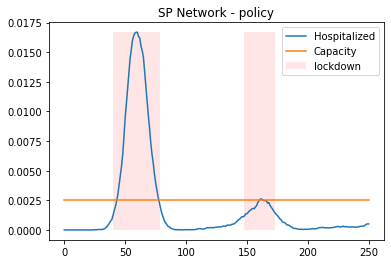

In [29]:
plt.plot(time_series.index, time_series['hospitalized'], label = 'Hospitalized')
plt.plot(time_series.index, len(time_series.index)*[0.0025], label = 'Capacity')
plt.title(f'SP Network - policy')
plt.fill_between(time_series.index[:-1], time_series['hospitalized'].max(), where=np.array(restrictions)[:,1] == 1,
                facecolor='red', alpha=0.1, label='lockdown')
plt.legend()
plt.title(f'SP Network - policy')
plt.savefig(f'Hospital Beds- policy.png', fromat='png', dpi = 300)
plt.show()


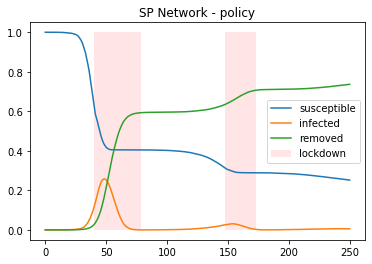

In [30]:
plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
plt.plot(time_series.index, time_series['removed'], label = 'removed')
plt.fill_between(time_series.index[:-1], 0, 1, where=np.array(restrictions)[:,1] == 1,
                facecolor='red', alpha=0.1, label='lockdown')
plt.legend()
plt.title(f'SP Network - policy')
plt.savefig(f'SP network Simulation- policy.png', fromat='png', dpi = 300)
plt.show()


In [80]:
import seaborn as sns
nx.draw(subgraph_of_zone(G, 20, 'home'), node_size=10, pos=nx.spring_layout(G))

KeyboardInterrupt: 

In [77]:
import networkx as nx
import plotly.graph_objects as go

def plot_graph(G):

    #pos = nx.spectral_layout(G)
    pos = nx.spring_layout(G)

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))


    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),))
    fig.show()


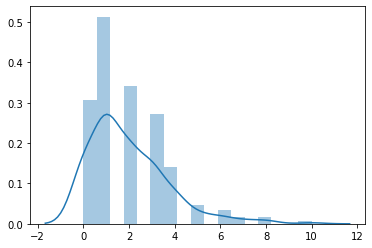

In [65]:
sns.distplot([y for x,y in subgraph_of_zone(G, 75, 'home').degree()])